In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load the HDF5 file containing the samples
data = h5py.File('/home/max/Documents/output_32x32/samples.h5', 'r')

# Lattice size
L = 32

# Get all samples from the HDF5 file
samples = np.array([np.array(data[f"step_{step:05d}"]["sample"]).reshape(512,L, L, order="C") for step in range(1, len(data.keys()))]).reshape(-1,L, L)
n_samples = len(samples)

2000
<KeysViewHDF5 ['Eo', 'Ev', 'abs_mag', 'abs_mag_var', 'mag', 'mag_var', 'sample', 'sq_mag', 'sq_mag_var', 'stag_mag', 'stag_mag_var', 'time']>


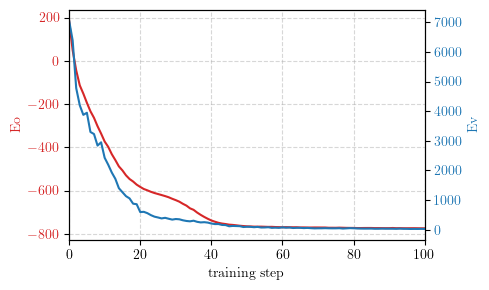

In [3]:
# use latex font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Eo = np.array([data[f"step_{str(i).zfill(5)}"]['Eo'][()] for i in range(len(data.keys()))])
Ev = np.array([data[f"step_{str(i).zfill(5)}"]['Ev'][()] for i in range(len(data.keys()))])

fig, ax1 = plt.subplots(figsize=(5,3))

color = 'tab:red'
ax1.set_xlabel('training step')
ax1.set_ylabel('Eo', color=color)
ax1.plot(Eo, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Ev', color=color)  # we already handled the x-label with ax1
ax2.plot(Ev, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.xlim(0,100)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.grid(linestyle='--', alpha=0.5)
plt.savefig('energy_plot_32x32.png', dpi=300, bbox_inches='tight')
plt.show()

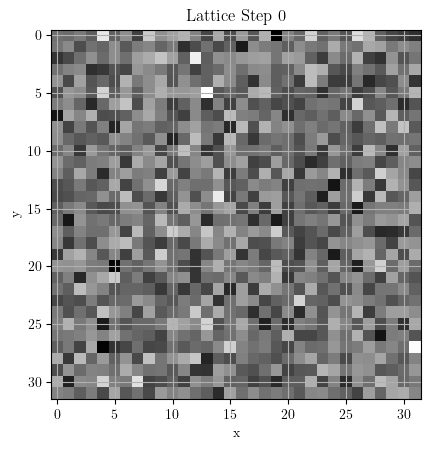

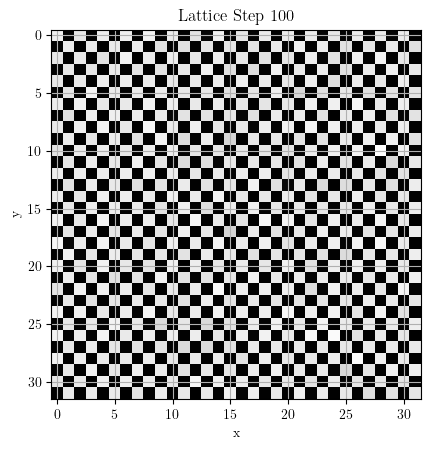

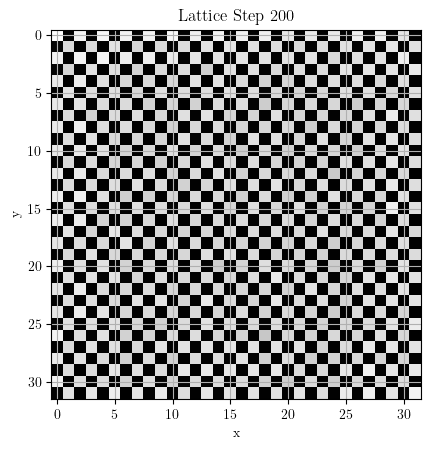

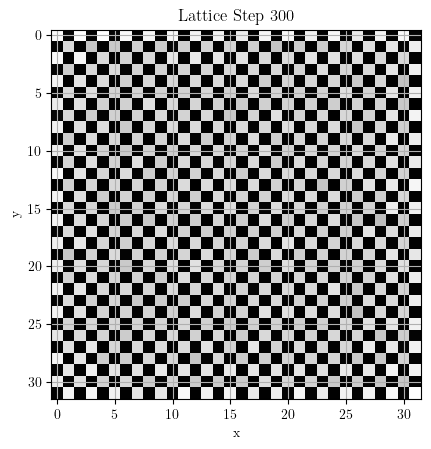

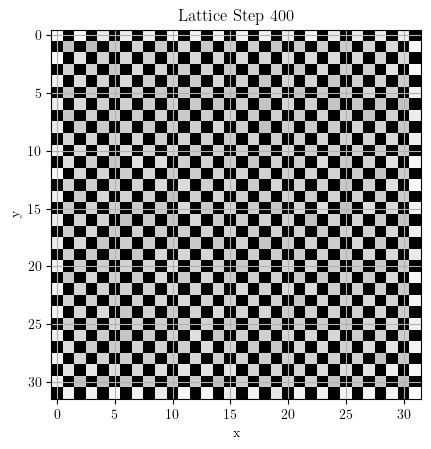

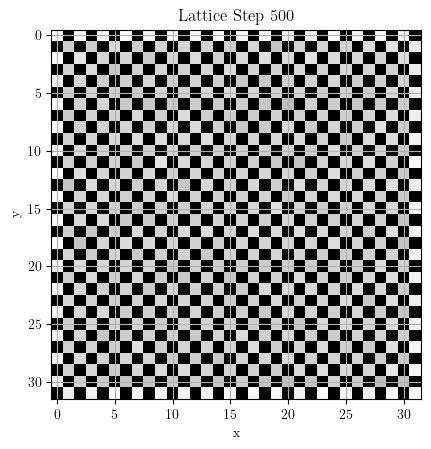

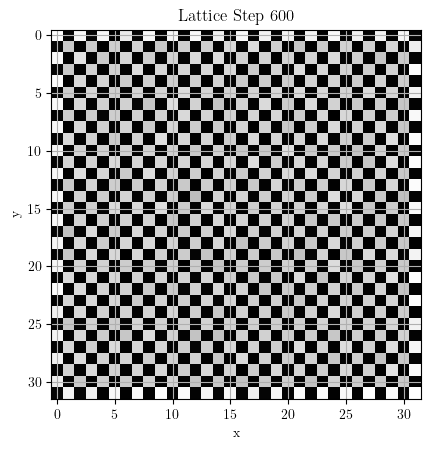

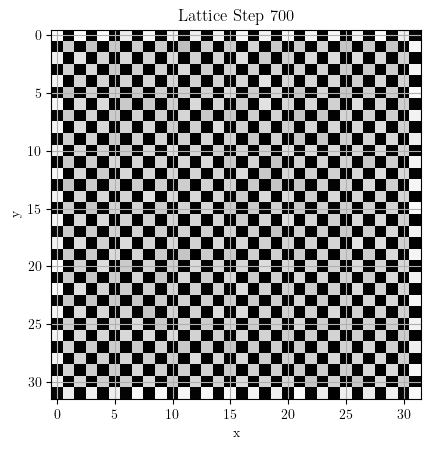

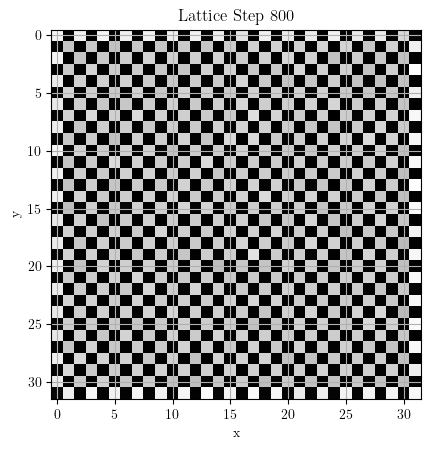

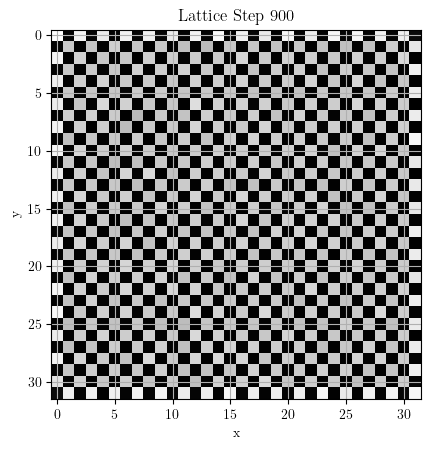

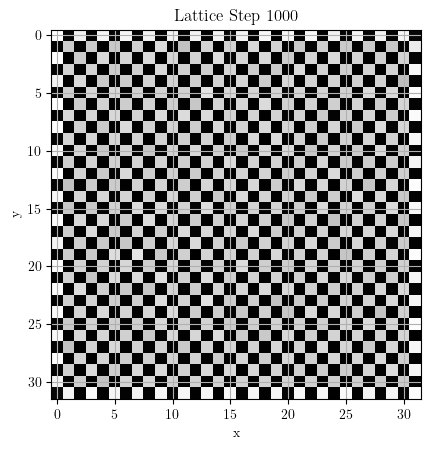

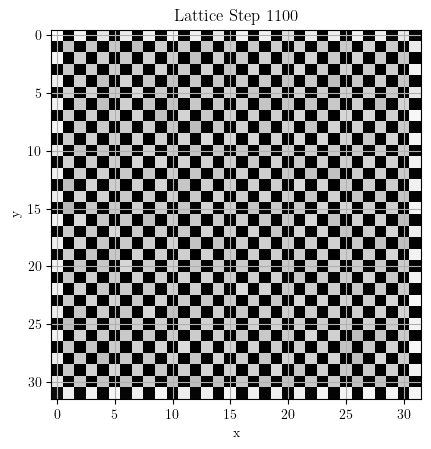

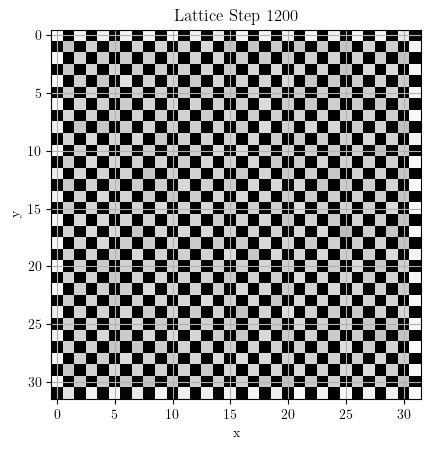

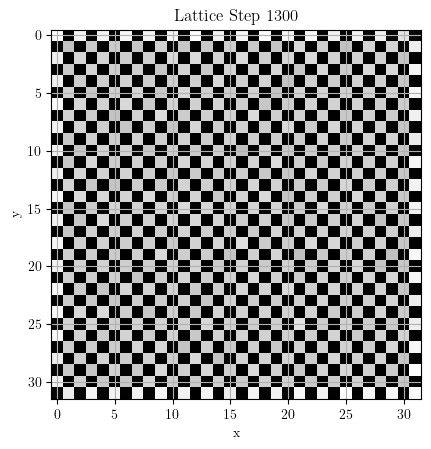

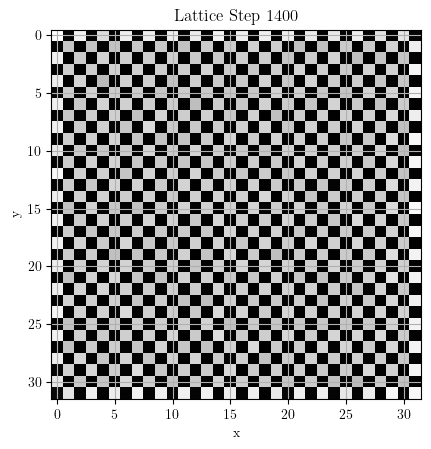

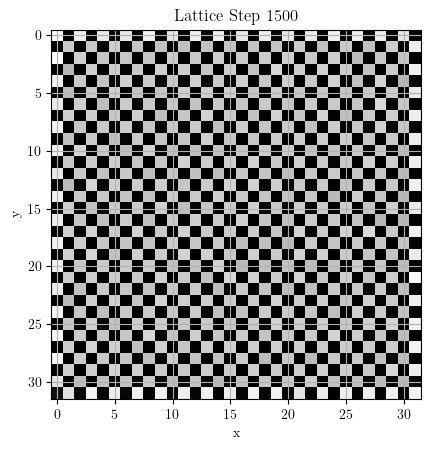

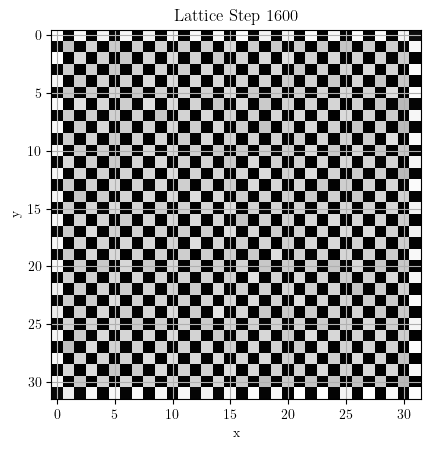

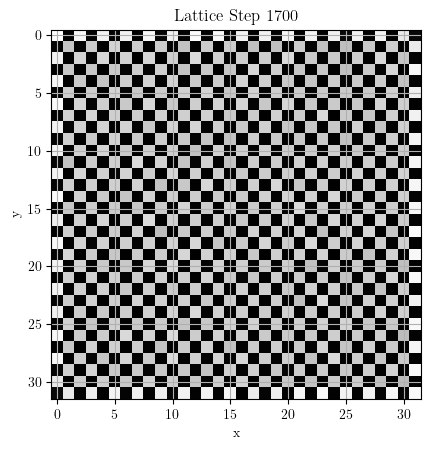

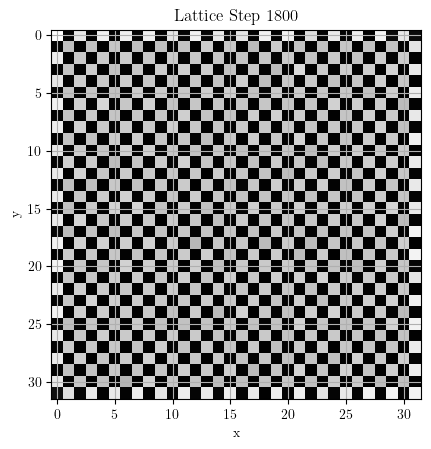

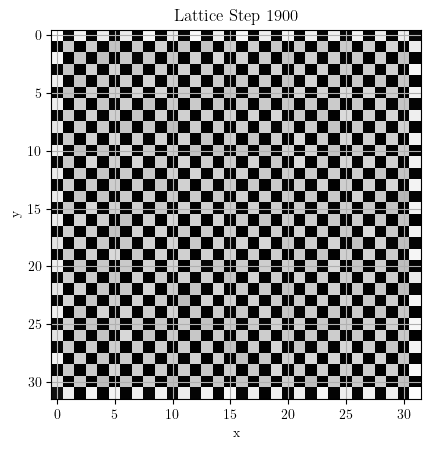

In [ ]:
every = 100
for step in range(len(data.keys()))[::every]:
    # Average over the batch dimension and reshape to square lattice
    samples_avg = np.mean(np.array(data[f"step_{step:05d}"]["sample"]), axis=0).reshape(32,32, order="C")
    # samples_avg = np.array(data[f"step_{step:05d}"]["sample"])[0].reshape(12, 12, order="C")
    
    # Plot the average lattice
    plt.imshow(samples_avg, cmap='gray')
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Lattice Step {step}")
    plt.grid()
    plt.show()

In [ ]:
def staggered_density(config):
    Lx, Ly = config.shape
    checkerboard = np.fromfunction(lambda i, j: (-1)**(i + j), (Lx, Ly))
    return np.sum(config * checkerboard) / (Lx * Ly)

# Compute order parameter for each sample
phi_vals = np.array([staggered_density(sample) for sample in samples])
phi_vals = np.mean(samples.reshape(n_samples, -1), axis=1)
# print(phi_vals)

# Histogram P(φ)
bins = 30
hist, bin_edges = np.histogram(phi_vals, bins=bins, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Compute effective potential V_eff(φ) = -log P(φ)
V_eff = -np.log(hist + 1e-12)  # Add epsilon to avoid log(0)
V_eff -= np.min(V_eff)         # Normalize so minimum is at 0

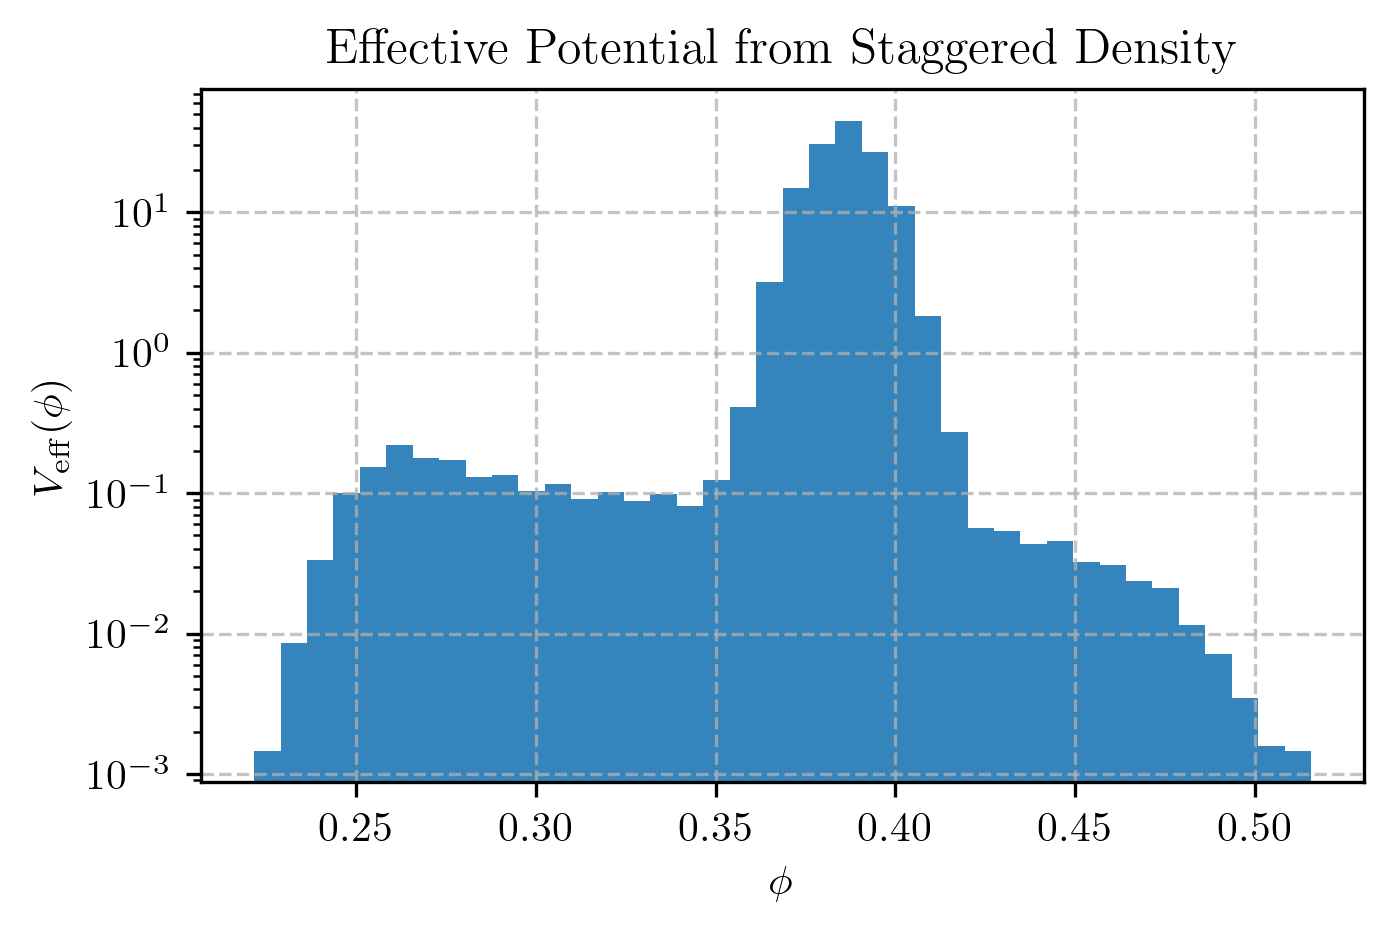

In [37]:
plt.figure(figsize=(5, 3), dpi=300)
plt.hist(phi_vals, bins=40, density=True, alpha=0.9, label='Histogram of $\phi$')
plt.xlabel('$\phi$')
plt.ylabel('$V_{\mathrm{eff}}(\phi)$')
plt.title('Effective Potential from Staggered Density')
plt.yscale("log")
plt.grid(linestyle="--", alpha=0.75)

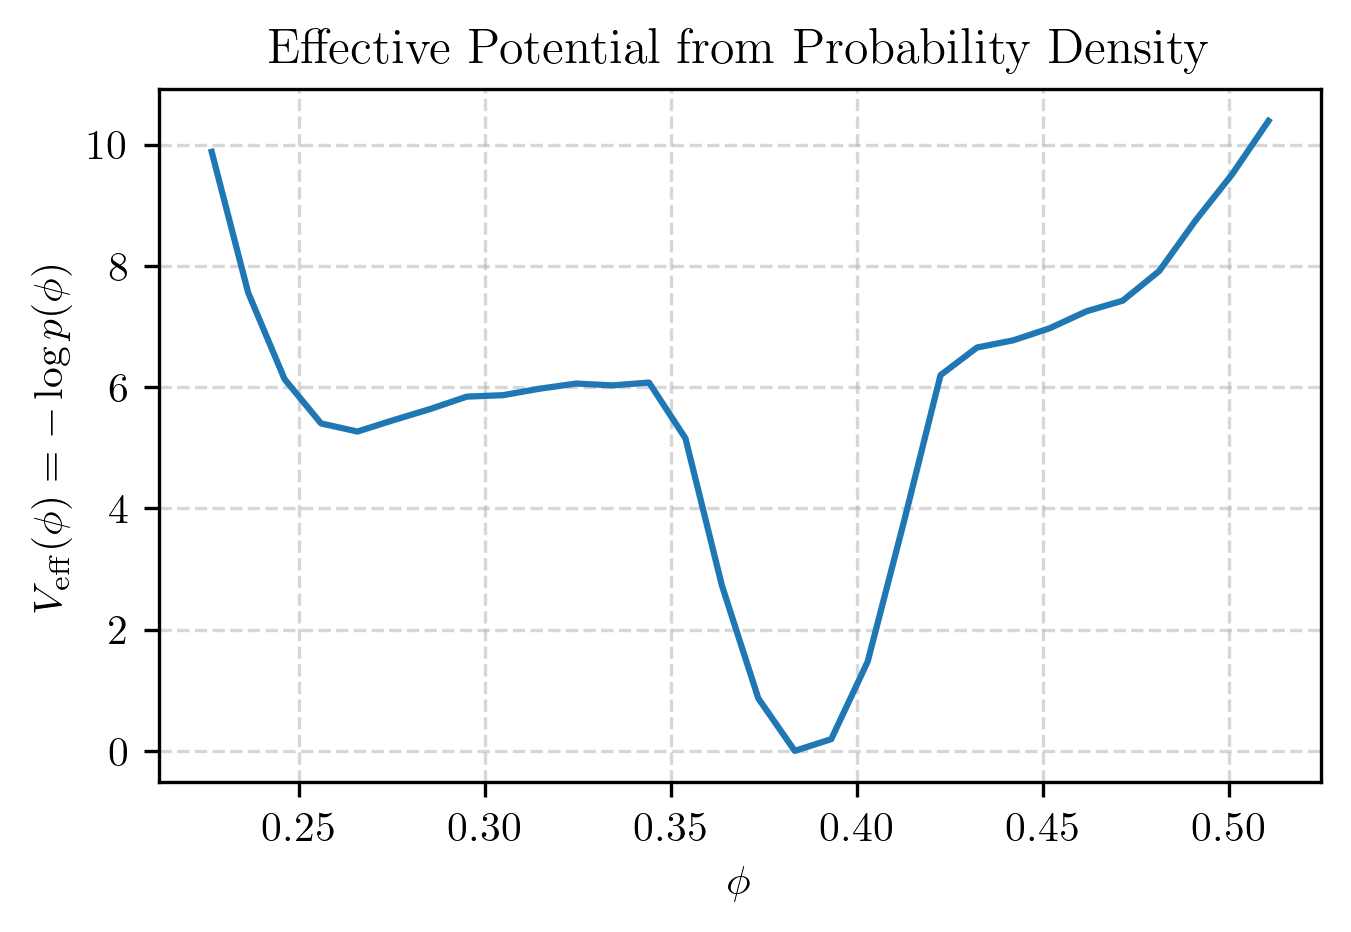

In [42]:

plt.figure(figsize=(5, 3), dpi=300)
plt.plot(bin_centers, V_eff, label='Effective potential')
plt.xlabel('$\phi$')
plt.ylabel('$V_{\mathrm{eff}}(\phi)=-\log p(\phi)$')
plt.title('Effective Potential from Probability Density')
plt.grid(linestyle="--", alpha=0.5)

/home/max/Repos/VMC_with_LPTFs/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3667: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


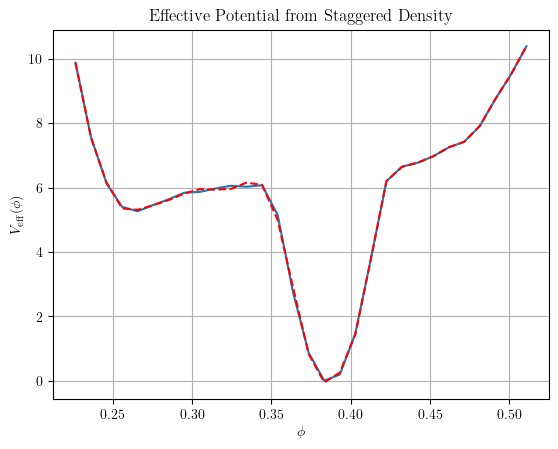

In [45]:


coeffs = np.polyfit(bin_centers, V_eff, 100)
p = np.poly1d(coeffs)

plt.plot(bin_centers, V_eff, label='Effective potential')
plt.plot(bin_centers, p(bin_centers), 'r--', label='Polynomial fit')
plt.xlabel('$\phi$')
plt.ylabel('$V_{\mathrm{eff}}(\phi)$')
plt.title('Effective Potential from Staggered Density')
plt.grid()

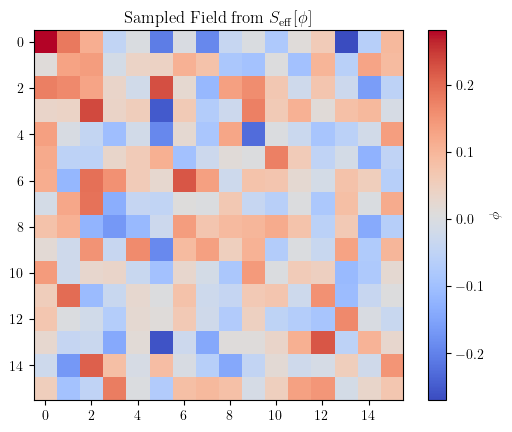

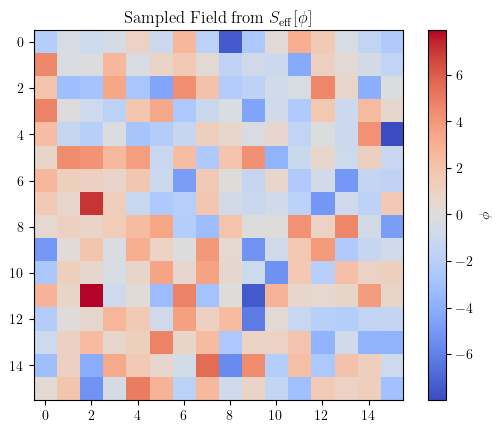

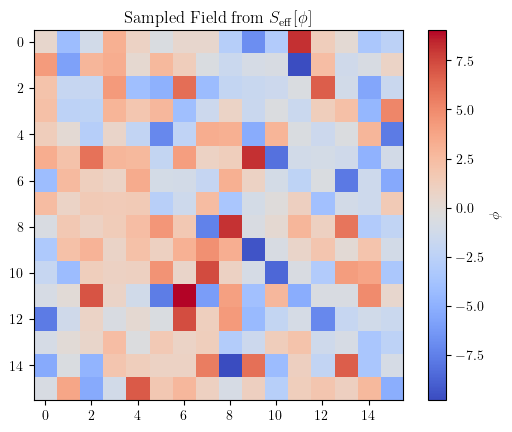

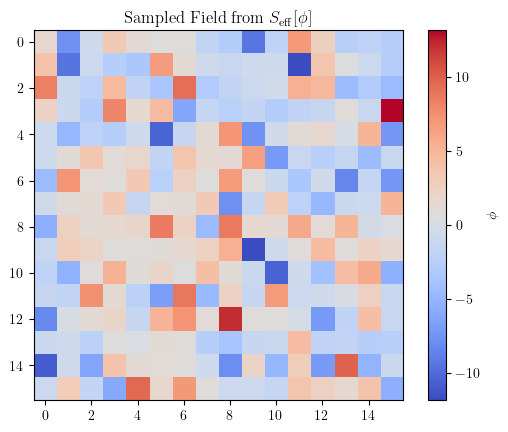

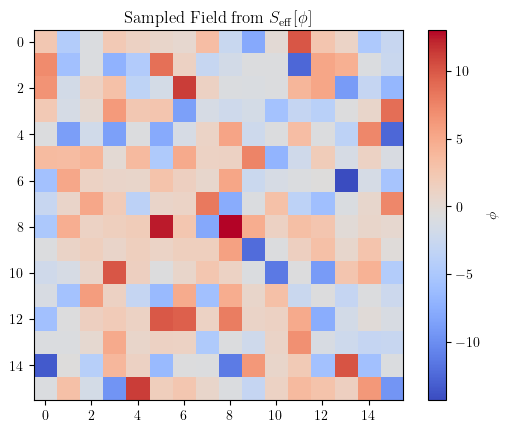

/tmp/ipykernel_27698/241652799.py:40: RuntimeWarning: overflow encountered in exp
  if np.random.rand() < np.exp(-dS):


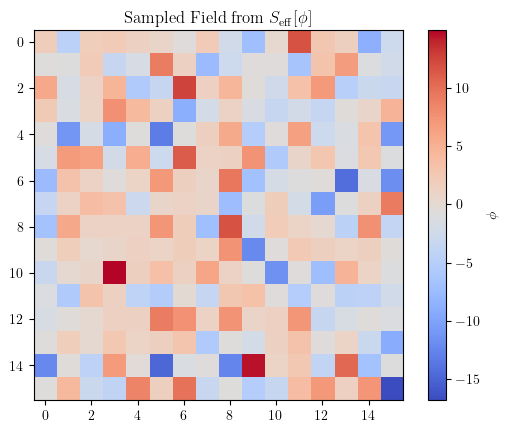

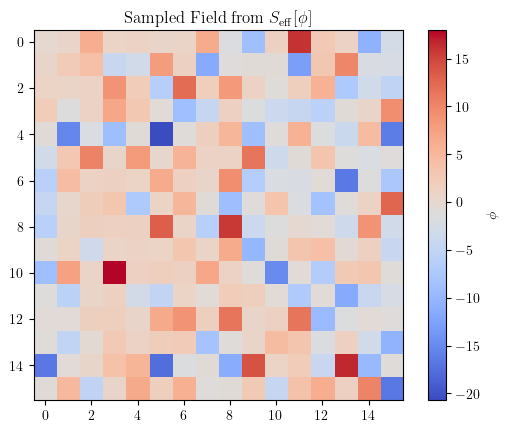

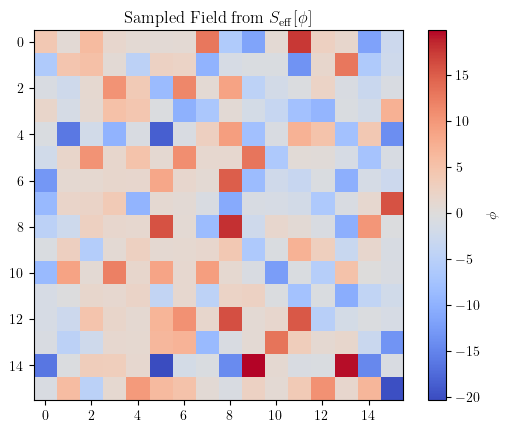

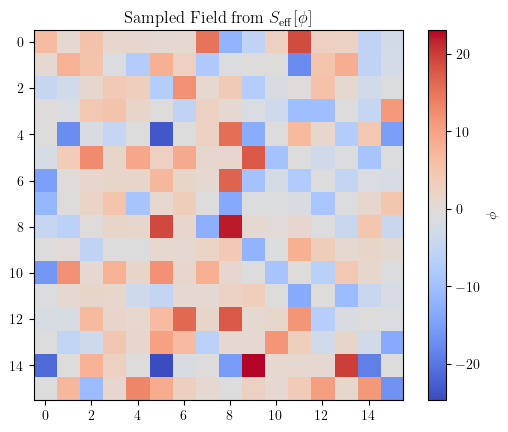

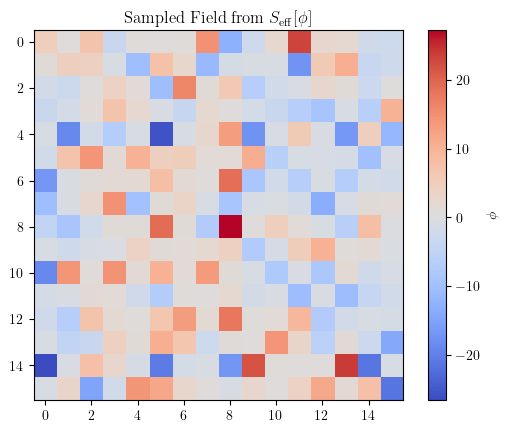

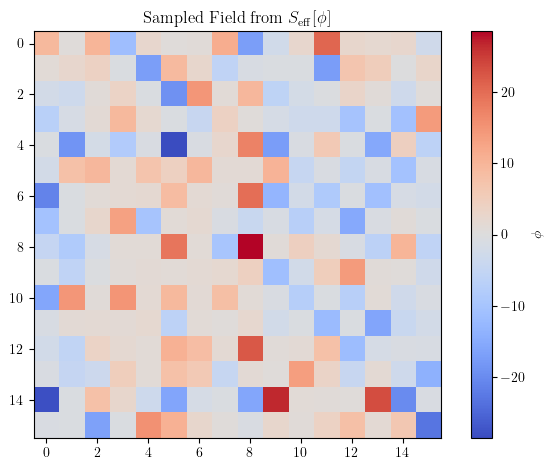

In [46]:
# --- 6. Sample from the effective action in 2D via Metropolis
size = 16
n_sweeps = 10000
beta = 1.0  # inverse temperature
step_size = 0.1

# Initialize phi field
phi = np.abs(np.random.normal(0, 0.01, size=(size, size)))
#phi = np.random.choice([0, 1], size=(size, size), p=[0.5, 0.5])  # Binary field for Rydberg excitation

# Energy function (lattice gradient + potential)
def local_action(phi_field, i, j):
    phi_val = phi_field[i, j]
    pot = p(phi_val)
    neighbors = (
        phi_field[(i + 1) % size, j] +
        phi_field[(i - 1) % size, j] +
        phi_field[i, (j + 1) % size] +
        phi_field[i, (j - 1) % size]
    )
    grad_term = 0.5 * (4 * phi_val**2 - 2 * phi_val * neighbors)
    return beta * (grad_term + pot)

# Metropolis–Hastings updates
for sweep in range(n_sweeps):
    for i in range(size):
        for j in range(size):
            old = phi[i, j]
            new = old + np.random.normal(0, step_size)
            dS = (
                local_action(phi, i, j)
                - p(old)
                - 0.5 * (4 * old**2 - 2 * old * (
                    phi[(i + 1) % size, j] +
                    phi[(i - 1) % size, j] +
                    phi[i, (j + 1) % size] +
                    phi[i, (j - 1) % size]
                ))
            )
            if np.random.rand() < np.exp(-dS):
                phi[i, j] = new
    if sweep % 1000 == 0:
        plt.imshow(phi, cmap='coolwarm', interpolation='nearest')
        plt.colorbar(label=r'$\phi$')
        plt.title('Sampled Field from $S_{\mathrm{eff}}[\phi]$')
        plt.show()

# --- 7. Plot sampled field configuration
plt.imshow(phi, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label=r'$\phi$')
plt.title('Sampled Field from $S_{\mathrm{eff}}[\phi]$')
plt.tight_layout()
plt.show()